## **Assignment Three (EECS3404 W25)**

**your name (your student number):** \\
**your yorku email:**

This assignment is mainly for you to review neural networks and deep learning models. You have to work individually. Remember to fill in your information (name, student number, email) at above.


##**What to Submit**

Use **one** notebook file (*.ipynb*) for **each** question, which should contain all of your answers and codes. You must zip all three notebooks into one zip file to submit it onto eClass.
No late submission will be accepted.

* For all written parts, write your answers in text cells. To avoid confusions in marking, better to embed latex codes there to represent all mathematical notations and equations.  No handwriting is accepted.

* For programming parts, you should give codes, comments, explanations and the proper running outputs in both code and text cells. Make your jupyter notebook clean and concise. Remove all unused codes and all intermediate results from the submitted notebook. The submitted notebook should include only the final (best) outputs for each question. Also make sure every code cell runnable so that markers can reproduce the outputs if necessary.

In [1]:
# download MNIST data from Google drive

!gdown --folder https://drive.google.com/drive/folders/1r20aRjc2iu9O3kN3Xj9jNYY2uMgcERY1 2> /dev/null

# install python_mnist

!pip install python_mnist
!pip install datasets

Processing file 1Jf2XqGR7y1fzOZNKLJiom7GmZZUzXhfs t10k-images-idx3-ubyte
Processing file 1qiYu9dW3ZNrlvTFO5fI4qf8Wtr8K-pCu t10k-labels-idx1-ubyte
Processing file 1SnWvBcUETRJ53rEJozFUUo-hOQFPKxjp train-images-idx3-ubyte
Processing file 1kKEIi_pwVHmabByAnwZQsaMgro9XiBFE train-labels-idx1-ubyte
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

### **Q1** (20 marks) **Deep Neural Networks for nonlinear feature extraction**


Based on [the implementation of fully-connected deep neural networks at Colab](https://colab.research.google.com/drive/17tsPsWo3aEC9Aldi0umNkrVH0BXtUhnj), use `JAX` autograd to implement a nonlinear feature extraction method using deep neural networks:

*   Bottleneck features (Section 4.4.2)

for the MNIST data.

Use all training data of 10 digits to train these the Bottleneck feature extractor and  investigate various network structures (such as different number of layers and nodes per layer) for the best possible classification performance. When you measure the classification performance, please use the best
 `scikit-learn` nonlinear SVM (Gaussian kernel) code as you did in **Assignment 2** to implement a binary classifier on the extracted features of the training data of two digits ('1' vs. '7').

 At last,  report the best configuration and its corresponding classification accuracy in the heldout test images for two digits ('1' vs. '7').
Discuss your findings in experiments.


In [ ]:
from datasets import load_dataset
import numpy as np
from sklearn.svm import SVC

trainset = load_dataset('mnist', split='train')
train_data = trainset['image']
train_label = trainset['label']

testset = load_dataset('mnist', split='test')
test_data = testset['image']
test_label = testset['label']

train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_data = np.reshape(train_data,(60000,28*28))
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_data = np.reshape(test_data,(10000,28*28))
test_label = np.array(test_label, dtype='short')

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

# prepare digits '1' and '7' for binary SVMs

digit_train_index = np.logical_or(train_label == 1, train_label == 7)
X_train = train_data[digit_train_index]
Y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 1, test_label == 7)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# normalize all feature vectors to unit-length
X_train = np.transpose (X_train.T / np.sqrt(np.sum(X_train*X_train, axis=1)))
X_test =  np.transpose (X_test.T  / np.sqrt(np.sum(X_test*X_test, axis=1)))

# convert labels: '1' => -1, '7' => +1
CUTOFF = 6 # any number between '1' and '7'
y_train = np.sign(Y_train-CUTOFF)
Y_test = np.sign(y_test-CUTOFF)

class mySVM2():
  def __init__(self, kernel='linear', optimizer='pgd', debug=0, threshold=0.001, \
               lr=1.0, max_epochs=20, batch_size=2, C=1, order=3, gamma=1.0):
    self.kernel = kernel           # kernel type
    self.optimizer = optimizer     # which optimizer is used to solve quadratic programming
    self.lr = lr                   # max learning rate in PGD
    self.max_epochs = max_epochs   # max epochs in PGD
    self.batch_size = batch_size   # size of each subset in PGD
    self.debug = debug             # whether print debugging info
    self.threshold = threshold     # threshold to filter out support vectors

    self.C = C                     # C for the soft-margin term
    self.order = order             # power order for polynomial kernel
    self.gamma = gamma             # gamma for Gaussian RBF kernel

  # Kernel Function
  # X[N,d]: training samples;  Y[M,d]: other training samples
  # return Q[N,N]: linear kernel matrix between X and Y
  def Kernel(self, X, Y):
    if (self.kernel == 'linear'):
      K = X @ Y.T
    elif (self.kernel == 'poly'):
      K = np.power(X @ Y.T +1, self.order)
    elif (self.kernel == 'rbf'):
      d1 = np.sum(X*X, axis=1)
      d2 = np.sum(Y*Y, axis=1)
      K = np.outer(d1, np.ones(Y.shape[0])) + np.outer(np.ones(X.shape[0]), d2) \
          - 2 * X @ Y.T
      K = np.exp(-self.gamma * K)

    return K

  # construct matrix Q from any kernel function for dual SVM optimization
  def QuadraticMatrix(self, X, y):
    Q = np.outer(y, y) * self.Kernel(X, X)
    return Q

  # use projected gradient descent to solve quadratic program
  # refer to Algorithm 6.5 on page 127
  # Q[N,N]: quadratic matrix;  y[N]: training labels (+1 or -1)
  def PGD(self, Q, y):
    N = Q.shape[0]   # num of training samples
    alpha = np.zeros(N)
    prev_L = 0.0

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(N)  #randomly shuffle data indices
      for batch_start in range(0, N, self.batch_size):
        idx = indices[batch_start:batch_start + self.batch_size] # indices of the current subset
        alpha_s = alpha[idx]
        y_s = y[idx]

        grad_s = Q[idx,:] @ alpha - np.ones(idx.shape[0])
        proj_grad_s = grad_s - np.dot(y_s,grad_s)/np.dot(y_s, y_s)*y_s

        bound = np.zeros(idx.shape[0])
        bound[proj_grad_s < 0] = self.C

        eta = np.min(np.abs(alpha_s-bound)/(np.abs(proj_grad_s)+0.001))

        alpha[idx] -= min(eta, self.lr) * proj_grad_s

      L = 0.5 * alpha.T @ Q @ alpha - np.sum(alpha) # objectibve function
      if (L > prev_L):
        if (self.debug>0):
          print(f'Early stopping at epoch={epoch}! (reduce learning rate lr)')
        break

      if (self.debug>1):
        print(f'[PGD optimizer] epoch = {epoch}: L = {L:.5f}  (# of support vectors = {(alpha>self.threshold).sum()})')
        print(f'                 alpha: max={np.max(alpha)} min={np.min(alpha)} orthogonal constraint={np.dot(alpha,y):.2f}')

      prev_L = L

    return alpha

  # train SVM from training samples
  # X[N,d]: input features;  y[N]: output labels (+1 or -1)
  def fit(self, X, y):
    if(self.kernel != 'linear' and self.kernel != 'poly' and self.kernel != 'rbf'):
      print("Error: only linear/poly/rbf kernel is supported!")
      return

    Q = self.QuadraticMatrix(X, y)

    alpha = self.PGD(Q, y)

    #save support vectors (pruning all data with alpha==0)
    self.X_SVs = X[alpha>self.threshold]
    self.y_SVs = y[alpha>self.threshold]
    self.alpha_SVs = alpha[alpha>self.threshold]

    if(self.kernel == 'linear'):
      self.w = (self.y_SVs * self.alpha_SVs) @ self.X_SVs

    # estimate b
    idx = np.nonzero(np.logical_and(self.alpha_SVs>self.threshold,self.alpha_SVs<self.C-self.threshold))
    if(len(idx) == 0):
      idx = np.nonzero(self.alpha_SVs>self.threshold)
    # refer to the formula on page 125 (above Figure 6.11)
    b = self.y_SVs[idx] - (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, self.X_SVs[idx])
    self.b = np.median(b)

    return

  # use SVM from prediction
  # X[N,d]: input features
  def predict(self, X):
    if(self.kernel != 'linear' and self.kernel != 'poly' and self.kernel != 'rbf'):
      print("Error: only linear/poly/rbf kernel is supported!")
      return

    if(self.kernel == 'linear'):
      y = X @ self.w + self.b
    else:
      y = (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, X) + self.b

    return np.sign(y)

# nonlinear SVM (Gaussian RBF kernel): use sk-learn SVC functions
c = 2
g = 2
rbfSVM = SVC(kernel='rbf', C=c, gamma=g)
rbfSVM.fit(X_train,y_train)
predict = rbfSVM.predict(X_train)
train_acc = np.count_nonzero(np.equal(predict,y_train))/y_train.size
predict = rbfSVM.predict(X_test)
test_acc = np.count_nonzero(np.equal(predict,y_test))/y_test.size
print(f'nonlinear RBF SVM (C={c},gamma={g}): training accuracy={100*train_acc:.2f}%  test accuracy={100*test_acc:.2f}%')


(60000, 784) (60000,) (10000, 784) (10000,)
nonlinear RBF SVM (C=2,gamma=2): training accuracy=99.96%  test accuracy=99.77%


In [2]:
import numpy as np
import jax.numpy as jnp
import jax.nn as jnn
from jax import grad, random, device_put
from datasets import load_dataset
import matplotlib.pyplot as plt
from mnist import MNIST


mnist_loader = MNIST('MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training/test labels into 10-D one-hot vectors
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1
Y_test = np.zeros((y_test.size, y_test.max()+1))
Y_test[np.arange(y_test.size),y_test] = 1

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, Y_train.shape, y_test.shape, Y_test.shape)
class myMLP3():
  def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',\
               loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,\
               init_range=1.0, annealing=1.0):
    self.optimizer = optimizer     # which optimizer is used to learn
    self.lr = lr                   # initial learning rate in SGD
    self.annealing = annealing     # annealing rate in SGD
    self.max_epochs = max_epochs   # max epochs in optimization
    self.batch_size = batch_size   # mini-batch size in SGD
    self.debug = debug             # whether print debugging info
    self.activation=activation     # activation function
    self.loss = loss               # the loss used for training objective
    self.random_state=random_state # random state
    self.init_range=init_range     # range for initializing weights

    self.struct = struct           # network structure: e.g. [100], [500, 200],
                                   #                         [100,100,100]

  # initialize internal struct/variables for input/output
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets
  def initialization(self, X, Y):
    key = random.PRNGKey(self.random_state)

    input = X.shape[1]                # input dimension
    self.layers = len(self.struct)    # number of hidden layers
    self.W_b = [0]*(self.layers+1)    # list for all weight matrices

    # create weight matrices for all hidden layers
    for l in range(self.layers):
      output = self.struct[l]
      self.W_b[l] = device_put(4.90*(random.uniform(key,(input+1, output))-0.5)*self.init_range/jnp.sqrt(output+input))
      input = output

    # create weight matrix for output layer
    output = Y.shape[1]
    self.W_b[self.layers] = device_put(4.90*(random.uniform(key,(input+1, output))-0.5)*self.init_range/jnp.sqrt(output+input))

    return

  # forward pass to compute outputs for a mini-batch X
  # (refer to the box on page 166)
  # input  =>  X[B,d]: a batch of input vectors
  # return =>  y[B,K]
  def forward(self, W_b, X):

    # appending 1's to accomodate bias (see page 107)
    Z = jnp.hstack((X,jnp.ones((X.shape[0],1),dtype=X.dtype)))

    # forward pass from all hidden layers
    for l in range(self.layers):
      Z = jnn.relu(Z @ W_b[l])
      Z = jnp.hstack((Z,jnp.ones((Z.shape[0],1),dtype=Z.dtype)))

    # forward pass for output layer
    l = self.layers
    y = jnn.softmax(Z @ W_b[l], axis=1)


    return y

  # compute the CE loss for a mini-batch
  # W_b[ ]: list for all weight matrices
  # X[B,d]: input features;
  # Y[B,K]: 1-of-K one-hot vectors for output targets
  def loss_ce_batch(self, W_b, X, Y):
    R = self.forward(W_b, X)

    return -jnp.mean(jnp.log(R[Y==1]))

  # use minibatch SGD to optimize (refer to Algorithm 8.8 on page 189)
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets
  def sgd(self, X, Y):
    n = X.shape[0]      # number of samples

    lr = self.lr
    errorsA = np.zeros(self.max_epochs)
    #errorsB = np.zeros(self.max_epochs)
    errorsC = np.zeros(self.max_epochs)

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(n)  #randomly shuffle data indices
      for batch_start in range(0, n, self.batch_size):
        X_batch = X[indices[batch_start:batch_start + self.batch_size]]
        Y_batch = Y[indices[batch_start:batch_start + self.batch_size]]

        W_b_grad = grad(self.loss_ce_batch)(self.W_b, X_batch, Y_batch)

        for l in range(self.layers+1):
          self.W_b[l] -= lr * W_b_grad[l]

      # plot all learning curves (A, B, C)
      errorsC[epoch] = self.loss_ce_batch(self.W_b, X, Y)

      Z = self.forward(self.W_b, X)
      train_label = np.argmax(Y, axis=1)
      train_res = np.argmax(Z, axis=1)
      errorsA[epoch] = np.count_nonzero(np.equal(train_res,train_label))/train_label.size

      if(self.debug):
        print(f'epoch = {epoch} (lr={lr:.2}): C = {errorsC[epoch]:.5f}  A = {100*errorsA[epoch]:.2f}%')

      lr *= self.annealing

    return errorsA, errorsC

   # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets
  def fit(self, X, Y):
    # initialize all weight matrices
    self.initialization(X, Y)

    X2 = device_put(X)
    Y2 = device_put(Y)

    errorsA, errorsC = self.sgd(X2, Y2)

    return errorsA, errorsC

  # X[N,d]: input features;
  # return: labels
  def predict(self, X):
    X2 = device_put(X)
    Y = self.forward(self.W_b, X2)
    return jnp.argmax(Y, axis=1)



(60000, 784) (60000,) (10000, 784) (10000,) (60000, 10) (10000,) (10000, 10)


In [ ]:
mlp3 = myMLP3(struct=[500,250, 50, 250, 500], debug=1, max_epochs=10, annealing=0.98, batch_size=50,lr=0.1)

A, C = mlp3.fit(X_train, Y_train)

result = mlp3.predict(X_test)

test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
_=ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

_=ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

epoch = 0 (lr=0.1): C = 0.11440  A = 96.53%
epoch = 1 (lr=0.098): C = 0.07605  A = 97.63%
epoch = 2 (lr=0.096): C = 0.05510  A = 98.25%
epoch = 3 (lr=0.094): C = 0.03382  A = 98.93%
epoch = 4 (lr=0.092): C = 0.02474  A = 99.22%
epoch = 5 (lr=0.09): C = 0.02605  A = 99.16%
epoch = 6 (lr=0.089): C = 0.01881  A = 99.38%
epoch = 7 (lr=0.087): C = 0.00668  A = 99.80%
epoch = 8 (lr=0.085): C = 0.00855  A = 99.76%


In [ ]:
# Subset the test data for digits '1' and '7'
test_mask_17 = (y_test == 1) | (y_test == 7)
X_test_17 = X_test[test_mask_17]
y_test_17 = y_test[test_mask_17]  # Labels: 1 or 7
result_17 = result[test_mask_17]  # Predicted labels for '1' and '7'

# Compute accuracy for '1' vs. '7'
correct_17 = jnp.count_nonzero(jnp.equal(result_17, y_test_17))
total_17 = y_test_17.size
test_acc_17 = 100.0 * correct_17 / total_17
print(f"Test accuracy for digits '1' vs. '7' = {test_acc_17:.2f}%")

The results are slightly better.

### **Q2** (20 marks)  **Convolutional Neural Networks (CNN) for image classification**

Refer to [the example in this Colab notebook](https://colab.research.google.com/drive/1QjGuJy1Zu3VxPVyDAwMNq8rUaDSFqr_v), use `pytorch` to implement a CNN model as in Figure 8.23 on page 169 and evaluate it on the CIFAR10 data set. Vary the structures in this CNN model slightly to see whether you can further improve the performance on the *CIFAR10* test set. Report your best results and discuss your findings from experiments.

Refer to the following codes for how to load the *CIFAR10* data set.

100%|██████████| 170M/170M [00:03<00:00, 49.4MB/s]


number of images in the training set: 50000
number of images in the test set: 10000
size of first image in the training set = torch.Size([3, 32, 32]), its label = frog


/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


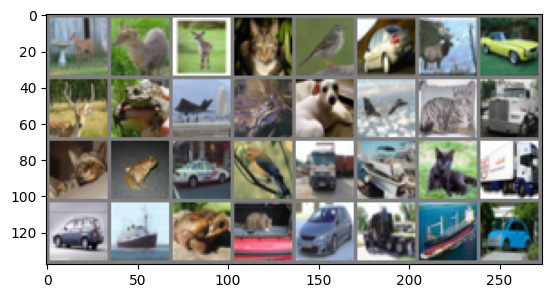

deer  deer  deer  cat   bird  car   deer  car   deer  frog  plane frog  dog   plane cat   truck cat   frog  car   bird  truck ship  cat   truck car   ship  frog  cat   car   truck ship  car  


In [4]:
# use torchvision to load Cifar10 image datasets.
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# function to preprocess cifar10 images
transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"number of images in the training set: {len(trainset)}")
print(f"number of images in the test set: {len(testset)}")
print(f"size of first image in the training set = {trainset[0][0].shape}, its label = {classes[trainset[0][1]]}")

# display images in the first batch and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# define CNN structure and its forward pass layer-by-layer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=256,kernel_size = 3),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Flatten(),
            nn.Linear(36864,128),
            nn.ReLU(),
            nn.Linear(128,10),
            nn.Softmax(dim=1)
            ]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #loss = F.cross_entropy(output, target)
        loss = F.nll_loss(torch.log(output), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(torch.log(output), target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


device = torch.device("cuda")
#device = torch.device("cpu")

model = Net().to(device)

#optimizer = optim.Adadelta(model.parameters(), lr=0.1)
optimizer= torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

for epoch in range(1, 11):
  train(model, device, trainloader, optimizer, epoch)
  test(model, device, testloader)
  scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.317073
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.662223

Test set: Average loss: 1.5148, Accuracy: 4622/10000 (46%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.676836
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.141790

Test set: Average loss: 1.0145, Accuracy: 6419/10000 (64%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.834488
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.507079

Test set: Average loss: 0.9910, Accuracy: 6645/10000 (66%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.142946
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.570046

Test set: Average loss: 0.8820, Accuracy: 7035/10000 (70%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.687591
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.716471

Test set: Average loss: 0.7860, Accuracy: 7346/10000 (73%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.348542
Train Epoch: 6 [32000/50000 (64%)]	Loss: 0.450745

Test set: Average loss: 0.8467, Accuracy: 7321/10000 (73%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.347997
Train Epoch: 7 [320

I found the best results by adding an extra convolotution layer, while keeping the hyperparameters the same with an accuracy of 76%. A lower learning rate caused inconsisitency in the resutls with a final accuracy of 73%, even with a the extra convolotution layer. Without the 3rd convolotution layer, the results were around 72%~73%

### **Q3** (20 marks)  **Transformers for Questions Answering**

Use [the transformer-based GPT implementation in the Colab notebook](https://colab.research.google.com/drive/1ZTHmfrYK1sDSfoHYXB-_Rb37OUCVOSXp) to implement a toy-example Question Answering system. Revise the GPT code to train on a new text dataset that includes some Trivia question and answer pairs. After that, sample the learned model to generate answers when using questions as prompts. Vary the model size and training hyperparameters in order to correctly answer as many questions as possible. For each question, you may sample five (5) times, treat it correct as long as one sampling generates the right answer.  Report your best results and discuss your findings in experiments.   

Here are the sample codes to download a tinyQA dataset which is used to train a small transformer-based GPT model for a question answering toy example.  It includes the following three files:

*   `train.txt`: a small training set consisting of some Trivial question and answer pairs.
*   `prompts.txt`: six prompts used to test the trained GPT model.
*   `answers.txt`: the answers to the six prompt questions.


In [5]:
# download the tiny Trivial Q/A dataset from Google drive
#
!gdown --folder https://drive.google.com/drive/folders/1cLjPppGCbjL6w31F1l70Q8qtzL-8pRUb?usp=share_link 2> /dev/null

Processing file 1aJNW3CKrwduxL35tBIya6TbaoNWWQc8Y answers.txt
Processing file 11KhbiY23sdpJkqzkIQQe4jLycPns6MdI prompts.txt
Processing file 1iUbTcBJEHSbA9R9OfMwKr0Lvt5S4Hbeh train.txt


In [6]:
# display the first few lines of training text, containing question and answer pairs

!cat tinyQA/train.txt | head -n 10


what was pierce brosnan's first outing as 007 [ goldeneye ]
the 02 arena is in which london borough [ greenwich ]
who wrote the 1956 novel '101 dalmatians' [ dodie smith ]
which band's first top ten single was the 10538 overture in 1972 [ electric light orchestra ]
the 1999 film 10 things i hate about you is based on which shakespeare play [ the taming of the shrew ]
the film `10 things i hate about you` is based on which shakespeare play [ the taming of the shrew ]
the film '10 things i hate about you', was inspired by which of shakespeare's plays [ the taming of the shrew ]
who directed the 2010 film 127 hours [ danny boyle ]
ciara had a hit with 1,2 step featuring which other artist [ missy elliot ]
which film director won the oscar for best picture for the film 12 years a slave in 2013 [ steve mcqueen ]
in which 2006 film does mark wahlberg try out for a university american football team [ invincible ]
'the black and gold' is a nickname of which american football team [ pittsburgh 

In [ ]:
# display the six questions as prompts

!cat tinyQA/prompts.txt

which football club did alan sugar own [
 'the black and gold' is a nickname of which american football team [ 
alex band and aaron kamin make up which band [
the aberdare mountains are in which african country [
which notable leader won the 2009 nobel peace prize [
who commanded the confederate army of northern virginia during the american civil war [ 


In [ ]:
# display the questions and answers for all prompts

!cat tinyQA/answers.txt

which football club did alan sugar own [ tottenham hotspur f.c. ]
'the black and gold' is a nickname of which american football team [ pittsburgh steelers ]
alex band and aaron kamin make up which band [ the calling ]
the aberdare mountains are in which african country [ kenya ]
which notable leader won the 2009 nobel peace prize [ barack obama ]
who commanded the confederate army of northern virginia during the american civil war [ robert e. lee ]


In [7]:
# load text file as a character string; build char-level vocabulary, encoder and decoder
#  (borrowed from nanoGPT, https://github.com/karpathy/nanoGPT)

train_txt_file = 'tinyQA/train.txt'

with open(train_txt_file, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

length of dataset in characters: 98,391
all the unique characters: 
 !#$%&'()*,-./0123456789:;[]_`abcdefghijklmnopqrstuvwxyz
vocab size: 57
train has 88,551 tokens
val has 9,840 tokens


In [8]:
# Define all parts in a GPT model, such as attention, MLP, LN modules
#  (adapted from nanoGPT, https://github.com/karpathy/nanoGPT)

import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

class config():
  def __init__(self, batch_size=10, n_layer=12, n_head=12, n_embd=768, block_size=1024, vocab_size=50304, causal=True, device='cpu'):
    assert n_embd %  n_head == 0
    self.batch_size = batch_size
    self.n_embd = n_embd
    self.block_size = block_size
    self.n_head = n_head
    self.causal = causal
    self.device = device
    self.n_layer = n_layer
    self.vocab_size = vocab_size

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=False)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size)).transpose(0,1)
                            .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, C // self.n_head, self.n_head).transpose(1, 3) # (B, nh, T, hs)
        q = q.view(B, T, C // self.n_head, self.n_head).transpose(1, 3) # (B, nh, T, hs)
        v = v.view(B, T, C // self.n_head, self.n_head).transpose(1, 3) # (B, nh, T, hs)

        att = (q.transpose(-2, -1) @ k) * (1.0 / math.sqrt(q.size(-2)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-2)
        y = v @ att  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 3).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=False)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.relu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm([config.n_embd])
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm([config.n_embd])

        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm([config.n_embd]),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        # Return the number of parameters in the model.
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):

        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)

            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [9]:
# training script to learn GPT models based on all given hyper-parameters
#  (adapted from nanoGPT, https://github.com/karpathy/nanoGPT)

import os
import time
import math

import numpy as np
import torch

# -----------------------------------------------------------------------------
# default config values
# I/O

######### model size ##########
n_layer = 3      # num of layers
n_head = 8       # num of attn heads per layer
head_size = 96   # size of each attn head
###############################

###### training hyperparameters ######
learning_rate = 6e-4   # max learning rate
max_iters = 10000      # total number of training iterations
batch_size = 24        # mini-batch size
block_size = 256       # block size
#####################################

# adamw optimizer
beta1 = 0.9
beta2 = 0.999

# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
eval_interval = 1000
eval_iters = 200

# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'bfloat16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler

torch.manual_seed(1337)

n_embd = n_head * head_size

data_tr  = np.array(train_ids, dtype=np.uint16)
data_val = np.array(val_ids, dtype=np.uint16)

# poor man's data loader
def get_batch(split):
    data = data_tr if split == 'train' else data_val

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# init a new model from scratch
print("Initializing a new model from scratch")
conf = config(batch_size=batch_size, n_layer=n_layer, n_head=n_head, n_embd=n_embd,\
              block_size=block_size, vocab_size=vocab_size, device=device)
model = GPT(conf)

model = model.to(device)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2))

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)


# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0

while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate

    logits, loss = model(X, Y)
    X, Y = get_batch('train')

    # backward pass, with gradient scaling if training in fp16
    scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0:
      # timing and logging
      t1 = time.time()
      dt = t1 - t0
      t0 = t1

      losses = estimate_loss()
      print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f} (time lapses {dt:.4f} seconds)")

    iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break


Initializing a new model from scratch
number of parameters: 21.29M


<ipython-input-9-7df8a51bfd57>:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


step 0: train loss 5.0748, val loss 5.0460 (time lapses 1.1134 seconds)
step 1000: train loss 1.8632, val loss 2.0615 (time lapses 283.2819 seconds)
step 2000: train loss 1.2955, val loss 2.0407 (time lapses 282.0643 seconds)
step 3000: train loss 0.1965, val loss 4.0200 (time lapses 280.5803 seconds)
step 4000: train loss 0.1178, val loss 4.8693 (time lapses 280.0938 seconds)
step 5000: train loss 0.1035, val loss 5.2041 (time lapses 281.1528 seconds)
step 6000: train loss 0.0954, val loss 5.4100 (time lapses 280.7283 seconds)
step 7000: train loss 0.0848, val loss 5.4946 (time lapses 281.7341 seconds)
step 8000: train loss 0.0838, val loss 5.6617 (time lapses 280.8972 seconds)
step 9000: train loss 0.0831, val loss 5.7169 (time lapses 281.8602 seconds)
step 10000: train loss 0.0708, val loss 5.9187 (time lapses 282.3412 seconds)


In [11]:
# sample from a trained model to generate new text
# (borrowed from nanoGPT, https://github.com/karpathy/nanoGPT)

import torch

# start = "\n"     # specify a text string as prompt
start = "FILE:tinyQA/prompts.txt"  #can also specify a file of multiple prompts, use as: "FILE:prompt.txt"

num_samples = 5 # number of samples to draw
max_new_tokens = 100 # number of tokens generated in each sample
temperature = 0.7 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = None #200 # retain only the top_k most likely tokens, clamp others to have 0 probability

seed = 1337
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model.eval()
model.to(device)

# sampling the model based on one prompt
def SampleOnePrompt(prompt):
    start_ids = encode(prompt)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    for k in range(num_samples):
        y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        res = decode(y[0].tolist())
        answers = res.splitlines()
        print(answers[0])              # only show the first line for QA

        # sample = decode(y[0].tolist())
        # sampleAns = sample[:sample.index(']')+1]
        # print(sampleAns)    # show all sampling results
        print('---------------')


# encode the beginning of the prompt
if start.startswith('FILE:'):     # for multiple prompts
    with open(start[5:], 'r', encoding='utf-8') as f:
        Lines = f.readlines()
        for prompt in Lines:
            SampleOnePrompt(prompt[:-1])  # chop the trailing newline char
else:
     SampleOnePrompt(start)     # for one prompt


which football club did alan sugar own [ tottenham hotspur f.c. ]
---------------
which football club did alan sugar own [ tottenham hotspur f.c. ]
---------------
which football club did alan sugar own [ tottenham hotspur f.c. ]
---------------
which football club did alan sugar own [ tottenham hotspur f.c. ]
---------------
which football club did alan sugar own [ tottenham hotspur f.c. ]
---------------
 'the black and gold' is a nickname of which american football team [ steve cross ]
---------------
 'the black and gold' is a nickname of which american football team [ aria ]
---------------
 'the black and gold' is a nickname of which american football team [ steve cross ]
---------------
 'the black and gold' is a nickname of which american football team [ suday ]
---------------
 'the black and gold' is a nickname of which american football team [ are ]
---------------
alex band and aaron kamin make up which band [ the calling ]
---------------
alex band and aaron kamin make up 

The GPT got 4/6 questions right, the questions it got wrong were no near close, one of them was not legible. What got these result was doubling the batch size, block size, and beta2.

I was trying different configuration on the GPT model and maxed out the gpu limit on colab, on 4 differnt accounts, and get the training done in time for the deadline, it takes around 1 hour to train it with the larger block size.

please run the training script and rerun the test.


